In [1]:
import pandas as pd
import numpy as np
import librosa 
import IPython.display as ipd #palying audio
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import csv
import glob

import os

SR = 16000

In [2]:
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import entropy

In [3]:
def abs_fft(wave):
    return np.abs(np.fft.fft(wave))

In [4]:
feature_func_dict = {'chroma_stft': librosa.feature.chroma_stft,
                     'rms': librosa.feature.rms,
                     'spec_cent': librosa.feature.spectral_centroid,
                     'spec_bw': librosa.feature.spectral_bandwidth,
                     'rolloff': librosa.feature.spectral_rolloff,
                     'zcr': librosa.feature.zero_crossing_rate,
                     'mfcc': librosa.feature.mfcc,
                    'fft': abs_fft}

In [5]:
def extract_features(path, sr=SR):
    wave, sr = librosa.load(path, sr=sr)
    data = {}
    percentiles = [10*i for i in range(1, 10)]
    # Frequency ranges are for the fourier transform (np.fft.fft)
    # The fourier transform basically transforms the the wave into frequencies, with the fz range
    # we try to make frequency bands and take the average of them (low sounds, medium sounds etc...)
    frequencie_ranges = [(0, 5), (5, 20), (20, 50), (50, 200), (200, 500), (500, 2000), (2000, 5000), (5000, 20000), (20000, 50000), (50000, 160000)]
    
    # Some standard statistics you can take from an array, a lot of duplicate code that can be removed, made better
    # percentiles also contain the median (and could contain the min and max as well but not currently)
    
    # Statistics on the wave itself
    ## Percentiles
    for number, percent in zip(np.percentile(wave, percentiles), percentiles):
        data[f'array_percentile_{percent}'] = number
    ## Other statistics
    data['array_mean'] = np.mean(wave)
    data['array_median'] = np.median(wave)
    data['array_std'] = np.std(wave)
    data['array_kurtosis'] = kurtosis(wave)
    data['array_skew'] = skew(wave)
    #data['array_entropy'] = entropy(wave)
    data['array_min'] = np.min(wave)
    data['array_max'] = np.max(wave)
    for key, function in feature_func_dict.items():
        try:
            transformed_wave = function(y=wave, sr=SR)
        except TypeError:
            try:
                transformed_wave = function(y=wave)
            except TypeError:
                transformed_wave = function(wave)
        print(key, transformed_wave.shape)
                # Ugly if statements, could be done better
        if transformed_wave.shape == (1, 313):
            # Statistics on features we got with librosa, numpy
            ## Other statistics
            data[key + f'{key}_mean'] = np.mean(transformed_wave)
            data[f'{key}_median'] = np.median(transformed_wave)
            data[f'{key}_std'] = np.std(transformed_wave)
            data[f'{key}_kurtosis'] = kurtosis(transformed_wave, axis=1)[0]
            print(kurtosis(transformed_wave, axis=1))
            data[f'{key}_skew'] = skew(transformed_wave, axis=1)[0]
            data[f'{key}_entropy'] = entropy(transformed_wave, axis=1)[0]
            data[f'{key}_min'] = np.min(transformed_wave)
            data[f'{key}_max'] = np.max(transformed_wave)
            ## Percentiles
            for number, percent in zip(np.percentile(transformed_wave, percentiles), percentiles):
                data[f'{key}_percentile_{percent}'] = number
        elif key == 'fft':
            for hz_range in frequencie_ranges:
                
                data[f'{key}_{hz_range}'] = np.sqrt(np.mean(np.square(transformed_wave[hz_range[0]:hz_range[1]])))/(hz_range[1]-hz_range[0])
        else:
            print(key, transformed_wave.shape)
            #print(transformed_wave)
            mtw = np.mean(transformed_wave, axis=1)
            for i, row in enumerate(mtw):
                data[f'{key}_mean_{i}'] = row
            
    data['path'] = path
    return data, np.fft.fft(wave)

In [6]:
wave, sr = librosa.load('data/0_dB_pump/pump/id_04/normal/00000003.wav', sr=SR)

In [7]:
fft = np.abs(np.fft.fft(wave))

In [8]:
entropy(fft)

11.149630015436163

In [9]:
stft = librosa.feature.chroma_stft(wave)

In [10]:
entropy(stft).mean()

1.6261985

In [11]:
stft.std()

0.2688492

In [12]:
kurtosis(np.array([wave, wave]).T)

array([-0.39366937, -0.39366937], dtype=float32)

In [13]:
kurtosis(wave)

-0.3936693766789907

In [14]:
kurtosis([wave, wave])

array([-3., -3., -3., ..., -3., -3., -3.], dtype=float32)

In [15]:
entropy([wave, wave], axis=1)

array([-inf, -inf], dtype=float32)

In [16]:
data, fft = extract_features('data/0_dB_pump/pump/id_04/normal/00000003.wav')

chroma_stft (12, 313)
chroma_stft (12, 313)
rms (1, 313)
[0.26460052]
spec_cent (1, 313)
[-0.17093237]
spec_bw (1, 313)
[-0.24407641]
rolloff (1, 313)
[-0.35715611]
zcr (1, 313)
[5.51305057]
mfcc (20, 313)
mfcc (20, 313)
fft (160000,)


/home/simon/anaconda3/envs/codit/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


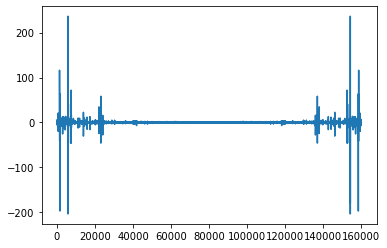

In [17]:
plt.plot(fft)

In [18]:
data

{'array_percentile_10': -0.010829925537109375,
 'array_percentile_20': -0.0073394775390625,
 'array_percentile_30': -0.004650115966796875,
 'array_percentile_40': -0.002262115478515625,
 'array_percentile_50': 3.814697265625e-06,
 'array_percentile_60': 0.002269744873046875,
 'array_percentile_70': 0.004638671875,
 'array_percentile_80': 0.00730133056640625,
 'array_percentile_90': 0.01074981689453125,
 'array_mean': -7.5998304e-07,
 'array_median': 3.8146973e-06,
 'array_std': 0.008240881,
 'array_kurtosis': -0.3936693766789907,
 'array_skew': 0.010042080655694008,
 'array_min': -0.029254913,
 'array_max': 0.029884338,
 'chroma_stft_mean_0': 0.02172114,
 'chroma_stft_mean_1': 0.20633693,
 'chroma_stft_mean_2': 1.0,
 'chroma_stft_mean_3': 0.21419743,
 'chroma_stft_mean_4': 0.05467424,
 'chroma_stft_mean_5': 0.037882704,
 'chroma_stft_mean_6': 0.22423503,
 'chroma_stft_mean_7': 0.1577163,
 'chroma_stft_mean_8': 0.017836675,
 'chroma_stft_mean_9': 0.01903625,
 'chroma_stft_mean_10': 0.01

In [19]:
def extract_features_from_list_of_paths(path_list: list):
    l = len(path_list)
    print(f'files: {l}')
    t0 = time()
    data_list = []
    for i, path in enumerate(path_list):
        if i % 1000 == 1:
            p_done = i/l*100
            print("{:.2f}%".format(p_done))
            t1 = time()
            td = t1-t0
            time_left = td / i * (l-i)
            print(f'Estimated time left: {int(time_left/60*100)/100} minutes')
        data_list.append(extract_features(path))
        
    df = pd.DataFrame(data_list)
    return df

In [20]:
glob.glob('data/0_dB_pump/*/*/*/*.wav')

['data/0_dB_pump/pump/id_04/normal/00000003.wav',
 'data/0_dB_pump/pump/id_04/normal/00000013.wav',
 'data/0_dB_pump/pump/id_04/normal/00000179.wav',
 'data/0_dB_pump/pump/id_04/normal/00000235.wav',
 'data/0_dB_pump/pump/id_04/normal/00000186.wav',
 'data/0_dB_pump/pump/id_04/normal/00000045.wav',
 'data/0_dB_pump/pump/id_04/normal/00000553.wav',
 'data/0_dB_pump/pump/id_04/normal/00000323.wav',
 'data/0_dB_pump/pump/id_04/normal/00000082.wav',
 'data/0_dB_pump/pump/id_04/normal/00000246.wav',
 'data/0_dB_pump/pump/id_04/normal/00000286.wav',
 'data/0_dB_pump/pump/id_04/normal/00000548.wav',
 'data/0_dB_pump/pump/id_04/normal/00000510.wav',
 'data/0_dB_pump/pump/id_04/normal/00000276.wav',
 'data/0_dB_pump/pump/id_04/normal/00000505.wav',
 'data/0_dB_pump/pump/id_04/normal/00000695.wav',
 'data/0_dB_pump/pump/id_04/normal/00000463.wav',
 'data/0_dB_pump/pump/id_04/normal/00000349.wav',
 'data/0_dB_pump/pump/id_04/normal/00000204.wav',
 'data/0_dB_pump/pump/id_04/normal/00000211.wav',


In [21]:
path_list = ['data/0_dB_pump/pump/id_00/abnormal/00000003.wav', 'data/0_dB_pump/pump/id_00/abnormal/00000013.wav', 'data/0_dB_pump/pump/id_00/abnormal/00000045.wav']

In [22]:
from time import time, sleep

In [23]:
list_paths_pump = glob.glob('data/*/valve/*/*/*.wav')


In [25]:
os.path.exists('features')

True

In [24]:
for machine in ['slider']:
    print(f'****************** {machine} ******************')
    print(f'****************** {machine} ******************')
    print(f'****************** {machine} ******************')
    t0 = time()
    list_paths_pump = glob.glob(f'data/*/{machine}/*/*/*.wav')
    df_data = extract_features_from_list_of_paths(list_paths_pump)
    t1 = time()
    print(t1-t0)
    df_data.to_csv(f'features/features_{machine}.csv')

****************** slider ******************
****************** slider ******************
****************** slider ******************
files: 11712
chroma_stft (12, 313)
chroma_stft (12, 313)
rms (1, 313)
[0.31187868]
spec_cent (1, 313)
[-0.99108323]
spec_bw (1, 313)
[-1.09296506]
rolloff (1, 313)
[-1.17544285]
zcr (1, 313)
[-0.28707541]
mfcc (20, 313)
mfcc (20, 313)
fft (160000,)
0.01%
Estimated time left: 38.86 minutes
chroma_stft (12, 313)
chroma_stft (12, 313)
rms (1, 313)
[0.37139082]
spec_cent (1, 313)
[-0.57830567]
spec_bw (1, 313)
[-0.42052594]
rolloff (1, 313)
[-0.41520838]
zcr (1, 313)
[-0.00360231]
mfcc (20, 313)
mfcc (20, 313)
fft (160000,)
chroma_stft (12, 313)
chroma_stft (12, 313)
rms (1, 313)
[-0.19876194]
spec_cent (1, 313)
[-1.52135201]
spec_bw (1, 313)
[-1.69600395]
rolloff (1, 313)
[-1.6585773]
zcr (1, 313)
[-0.47589489]
mfcc (20, 313)
mfcc (20, 313)
fft (160000,)
chroma_stft (12, 313)
chroma_stft (12, 313)
rms (1, 313)
[0.31130052]
spec_cent (1, 313)
[-1.23616866]


KeyboardInterrupt: 

In [ ]:
t0 = time()
df_data = extract_features_from_list_of_paths(list_paths_pump)
t1 = time()
print(t1-t0)

In [ ]:
2321/60


In [ ]:
df_data.to_csv('features/features_pump.csv')

In [ ]:
df_data

In [ ]:
feat_ylim_dict = {
    'rmse': (0, 0.035),
    'spec_cent': (1500, 4000),
    'spec_bw': (1700, 3500),
    'rolloff': (2000, 9000),
    'zcr': (0.05, 0.3),
    }